### Exercise: Get TensorBoard working with SVM
* Refer back to our linear regression example and add in plus modify the necessary code to get TensorBoard to work with SVM.
* It should mostly be the same, but the output of the loss function has a subtle difference so be careful!

### Support Vector Machines in TensorFlow
* Support Vector Machines (SVMs) are a machine learning method to separate binary classes.
* This is accomplished by maximizing a margin width between two classes.  
* It is extended to allow for noise in the data, when the two classes are not explicitly linear separable.  
* SVMs can be extended to separate non linear classes by using non-linear kernels.  
* After this, we show how to extend these binary classifiers into multi-class problems via a one-vs-all method.

<table><tr><td><img src='../pics/SVM-Planes.png' style="width: 250px"></td><td><img src='../pics/svm_support_vectors.jpeg' style="width: 250px"></td></td><td><img src='../pics/svmmaxmargin.jpg' style="width: 350px"></td></tr></table>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn import datasets

# Delete previous tensorboard graph
if os.path.exists('./tmp/lin_reg'):
    !rm /tmp/svm/*.*

tf.reset_default_graph()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load the data

We will use the iris data, specifically:
* $x_1 =$ Sepal Length
* $x_2 =$ Petal Width
* Class 1 : `I. setosa`
* Class -1: `not I. setosa`
* We know here that x and y are linearly separable for I. setosa classification.

>Note that we implement the soft margin with an allowable margin of error for points.  The margin of error term is given by 'alpha' below.  To behave like a hard margin SVM, set alpha = 0.

In [2]:
# Set a random seed and start a computational graph.
np.random.seed(42)
tf.set_random_seed(42)
sess = tf.Session()

In [3]:
# Load the data
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])

print(x_vals.shape,y_vals.shape)

(150, 2) (150,)


In [4]:
# Split data into train/test sets
train_indices = np.random.choice(len(x_vals),
                                 round(len(x_vals)*0.8),
                                 replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [5]:
# Set model parameters, placeholders, and coefficients.

# Declare batch size
batch_size = 120

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Create variables for SVM
A = tf.Variable(tf.random_normal(shape=[2, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

#### Declare our model and L2 Norm

SVM linear model is given by the equation:

$$\left[ \frac{1}{n} \sum_{i=1}^{n} \max(0, 1 - A \cdot x - b) \right] + \alpha \cdot ||A||^{2}$$

Our loss function will be the above quantity and we will tell TensorFlow to minimize it. Note that $n$ is the number of points (in a batch), $A$ is the hyperplane-normal vector (to solve for), $b$ is the hyperplane-offset (to solve for), and $\alpha$ is the soft-margin parameter.

#### Hard Margin vs. Soft Margin
<img src='../pics/softhardsvm.png'>
* Here we make our special loss function based on the classification of the points (which side of the line they fall on).
* Also, note that `alpha` is the soft-margin term and an be increased to allow for more erroroneous classification points.  For hard-margin behaviour, set `alpha = 0`.
* Hard margin SVM tends to overfit, so in general we use soft margin. We can tweak the alpha paramater to make sure our results seem reasonable

In [6]:
# Declare model operations
model_output = tf.subtract(tf.matmul(x_data, A), b)

# Declare vector L2 'norm' function squared
l2_norm = tf.reduce_sum(tf.square(A))

In [7]:
# Declare loss function
# Loss = max(0, 1-pred*actual) + alpha * L2_norm(A)^2
# L2 regularization parameter, alpha

alpha_value = 0.15
alpha = tf.constant([alpha_value])

# Margin term in loss
classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(model_output, y_target))))

# Put terms together
loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))

# YOUR CODE HERE


In [8]:
# Create the prediction function, optimization algorithm, and initialize the variables.
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target), tf.float32))

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

In [9]:
# Training loop
loss_vec = []
train_accuracy = []
test_accuracy = []
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)

    train_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_train,
        y_target: np.transpose([y_vals_train])})

    test_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_test,
        y_target: np.transpose([y_vals_test])})

    if (i + 1) % 100 == 0:
        print('Step #{} A = {}, b = {}'.format(
            str(i+1),
            str(sess.run(A)),
            str(sess.run(b))
        ))
        print('Loss = ' + str(temp_loss))

Step #100 A = [[ 0.32060686]
 [-2.0230381 ]], b = [[0.16066489]]
Loss = [0.7464491]
Step #200 A = [[ 0.2699794]
 [-1.6728768]], b = [[0.11058164]]
Loss = [0.59685844]
Step #300 A = [[ 0.22251599]
 [-1.4783534 ]], b = [[0.05141497]]
Loss = [0.59656423]
Step #400 A = [[ 0.1881822]
 [-1.3542182]], b = [[-0.01033501]]
Loss = [0.48249978]
Step #500 A = [[ 0.14973149]
 [-1.2619588 ]], b = [[-0.06808502]]
Loss = [0.52764094]


In [10]:
# Now we extract the linear coefficients and get the SVM boundary line.
# Extract coefficients
[[a1], [a2]] = sess.run(A)
[[b]] = sess.run(b)
slope = -a2/a1
y_intercept = b/a1

# Extract x1 and x2 vals
x1_vals = [d[1] for d in x_vals]

# Get best fit line
best_fit = []
upper_margin = []
lower_margin = []
for i in x1_vals:
    best_fit.append(slope*i+y_intercept)
    upper_margin.append(slope*i+y_intercept+alpha_value)
    lower_margin.append(slope*i+y_intercept-alpha_value)

# Separate I. setosa
setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == 1]
setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == 1]
not_setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == -1]
not_setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == -1]

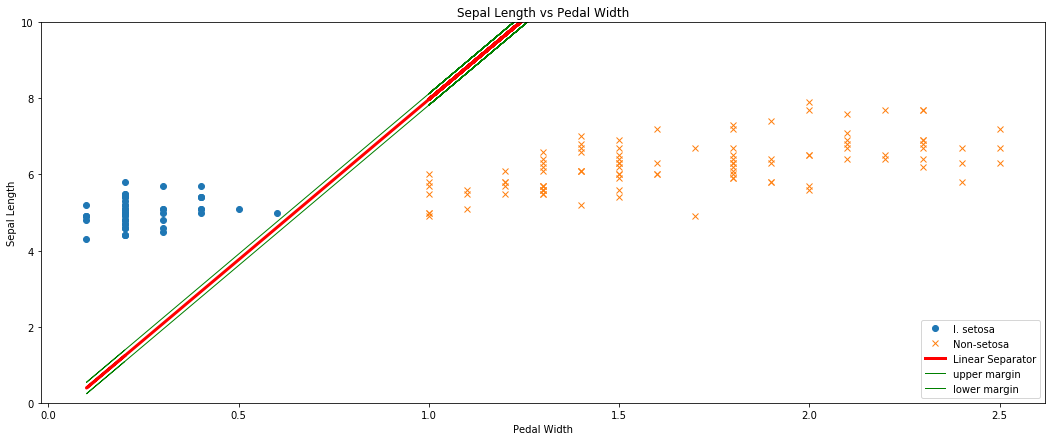

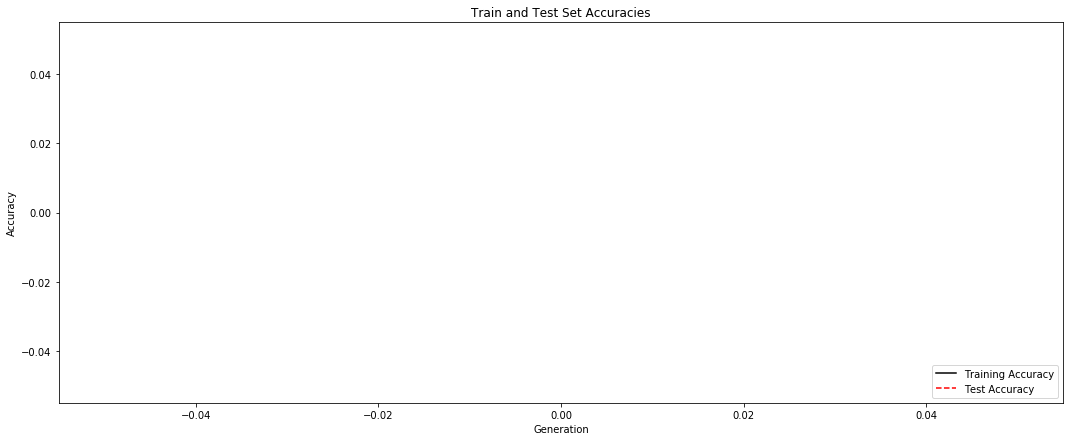

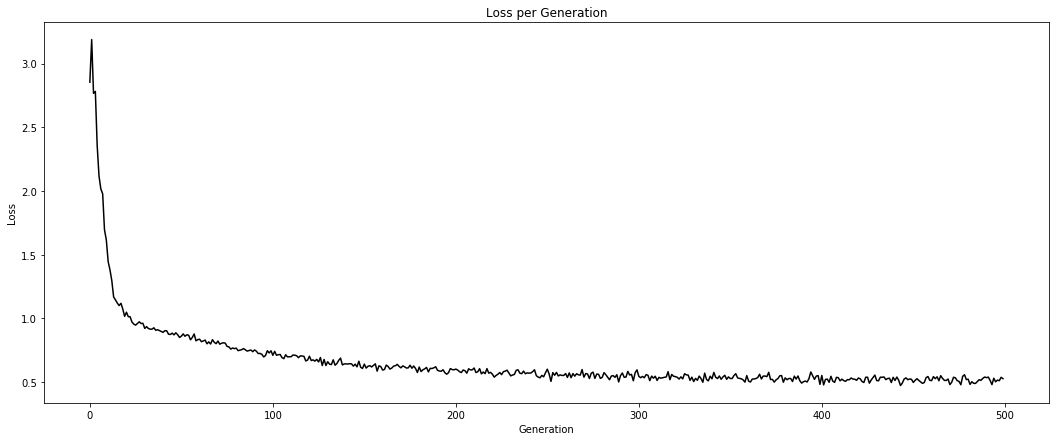

In [11]:
%matplotlib inline
# Plot data and line
plt.figure(figsize=(18,7))
plt.plot(setosa_x, setosa_y, 'o', label='I. setosa')
plt.plot(not_setosa_x, not_setosa_y, 'x', label='Non-setosa')
plt.plot(x1_vals, best_fit, 'r-', label='Linear Separator', linewidth=3)
plt.plot(x1_vals, upper_margin, 'g-', label='upper margin', linewidth=1)
plt.plot(x1_vals, lower_margin, 'g-', label='lower margin', linewidth=1)
plt.ylim([0, 10])
plt.legend(loc='lower right')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot train/test accuracies
plt.figure(figsize=(18,7))
plt.plot(train_accuracy, 'k-', label='Training Accuracy')
plt.plot(test_accuracy, 'r--', label='Test Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.figure(figsize=(18,7))
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [12]:
#!tensorboard --logdir=/tmp/svm